# California Housing Dataset Analysis

<div style="text-align: right"> *Everything Should Be Made as Simple as Possible, But Not Simpler -- Attributed to Albert Einstein* </div>
___

This notebook runs through an analysis of the california housing dataset using linear regression (Supervised machine learning) to predict the prices of houses based on certain feature engineering. This is done by determining the most impactful features on the root mean squared error after training convergence.

## Dataset and Context

The California housing dataset is based on the 1990 census data and pertains to houses in a given California district. It is an excellent dataset for an introduction to machine learning concepts because the data requires some extra cleaning steps, has easily understandable features and is just large enough to practice with the concepts of regularization and overfitting a model

link to dataset: https://storage.googleapis.com/mledu-datasets/california_housing_train.csv

Import necessary dependencies

In [1]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

Some formatting and clean up


In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
# Import the data from csv
california_housing_dataframe = (pd.
                                read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=","))

In [4]:
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0
...,...,...,...,...,...,...,...,...,...
16995,-124.3,40.6,52.0,2217.0,394.0,907.0,369.0,2.4,111400.0
16996,-124.3,40.7,36.0,2349.0,528.0,1194.0,465.0,2.5,79000.0
16997,-124.3,41.8,17.0,2677.0,531.0,1244.0,456.0,3.0,103600.0
16998,-124.3,41.8,19.0,2672.0,552.0,1298.0,478.0,2.0,85800.0



As the aim is to predict the label (median house values) based on a combination of one or more of the features (cols 1- 8) a keen understanding of the data set and the relationships between the individual features and the label is necessary. 

At first glance, the median_house_value column would be more relatable if scaled to a lesser value.

In [5]:
#scale the target data to be closer to readable values
california_housing_dataframe["median_house_value"] /= 1000.0

In [6]:
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5
...,...,...,...,...,...,...,...,...,...
16995,-124.3,40.6,52.0,2217.0,394.0,907.0,369.0,2.4,111.4
16996,-124.3,40.7,36.0,2349.0,528.0,1194.0,465.0,2.5,79.0
16997,-124.3,41.8,17.0,2677.0,531.0,1244.0,456.0,3.0,103.6
16998,-124.3,41.8,19.0,2672.0,552.0,1298.0,478.0,2.0,85.8


Throwing in every feature to train a model that predicts the target label (Median_house_value) would be counter intuitive as it exponentially increases the amount of processing power required. Also, only a subset of the features really have an impact on the median_house_values. This is where the importance of understanding a dataset comes into play. 

Majority of a ML workflow is focused on an actual understanding and cleaning up of the data to understand the relationships between features and the label, using these realtionships to select the most appropriate model, and fine tuning the model to be better at prediction. 

### Data Clipping

To have a general idea of the distribution of data in the dataset, we use

In [7]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


An interesting deduction can be immidiately made by examining the table above. For columns such as the "total_rooms" and "population", a few datapoints deviate substantially from the mean deviation. For "total_rooms" specifically, the 75th percentile of the column is 3151.2 and the maximum data point is 37937.This implies that about 5% or less of the data is significantly higher than the local mean. These outlying datapoints can substantially skew a linear regression model by affecting the linear loss and hence altering its weights significantly and reduce its prediction efficiency. They also increase convergence time.

To dive further into "total rooms" column, see the scatter plot below

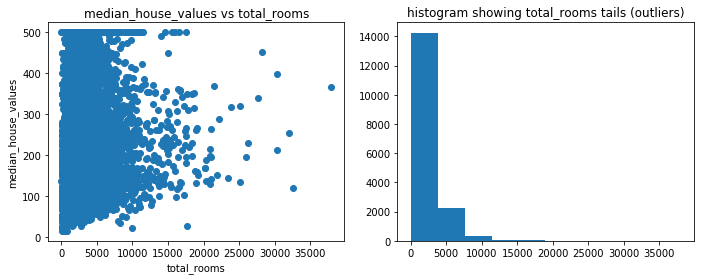

In [8]:
# set output figure size
plt.figure(figsize=(10, 4))
# make 2 plots
plt.subplot(1, 2, 1)
plt.scatter(california_housing_dataframe["total_rooms"],california_housing_dataframe["median_house_value"])
plt.title('median_house_values vs total_rooms')
plt.xlabel('total_rooms')
plt.ylabel('median_house_values')

plt.subplot(1, 2, 2)
plt.hist(california_housing_dataframe["total_rooms"])
plt.title('histogram showing total_rooms tails (outliers)')

#clean up the plots
plt.tight_layout()


It is obvious from the right scatter plot that the furthermost datapoints have a minute effect on the total dataset but will significantly affect the linear loss convergence negatively. 

To circumvent this challenge, we clip the data to a certain level. This limits the maximum size of the data to a reasonable value. This does not get rid of the outlying datapoints, it only reduces the effect they have on the general model.

for example, by clipping total_rooms to the 95th percentile (6269.0), we significantly reduce the effect of outliers whilst preserving the integrity of the dataset.

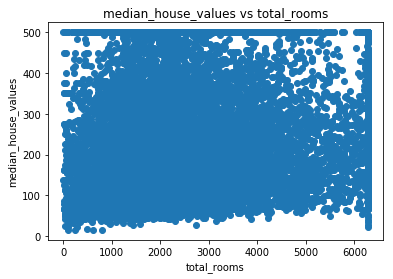

In [9]:
# extract the 95th percentile from the column
clip_value = california_housing_dataframe["total_rooms"].quantile(0.95)  

#clip the column using pandas clip function with the extracted value
clipped_total_rooms = california_housing_dataframe["total_rooms"].clip_upper(clip_value) 

#now replot the relationship between both median_house_values and total rooms
plt.scatter(clipped_total_rooms,california_housing_dataframe["median_house_value"])
plt.title('median_house_values vs total_rooms')
plt.xlabel('total_rooms')
plt.ylabel('median_house_values')
_ = plt.plot()


More agressive clipping can be done but it then becomes a tradeoff based how much of an effect clipping would have on the loss. 

### Determining optimal training features

We are getting ahead of ourselves though. Recall the initial objective of determining which features have the most impact on the training weights and loss? to revisit that, we examine the corellation between all the columns of the dataset. This can give insights as to which features are strongly correlated to the label and to each other. 

Features that are strongly correlated to other features provide little extra information to the model. See the table below.

In [10]:
# pearson correlation function
california_housing_dataframe.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0
population,0.1,-0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.0
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1
median_income,-0.0,-0.1,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.7
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0


The benchmark for the pearson correclation used above is as follows
* Perfect positive correlation +1
* Perfect negative correlation -1
* No correlation                0

median_income seems to easily stand out as the most important correlation to the target median_house_value. This implies that it was the single most important feature that affected the values of houses in california  in 1990. Throwing any other feature into the training mix would not justify the compute resources and is ultimately counter productive. 



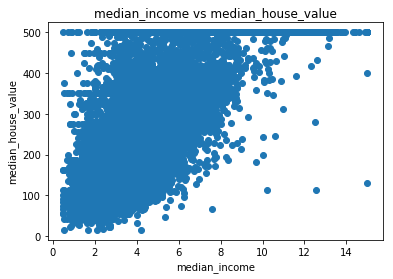

In [11]:
plt.title("median_income vs median_house_value")
plt.xlabel('median_income')
plt.ylabel('median_house_value')
plt.scatter(california_housing_dataframe["median_income"], california_housing_dataframe["median_house_value"])
_ = plt.plot()

### Binning

But this does not tell the full story. Everybody that has ever bought a house  or at least paid rent knows that the location of a house has a significant effect on the prices. Why doesnt our correlation function then indicate latitude or longitude as a dominant feature. To answer this, we examine a plot of Latitude/Logitude vs median_house_value

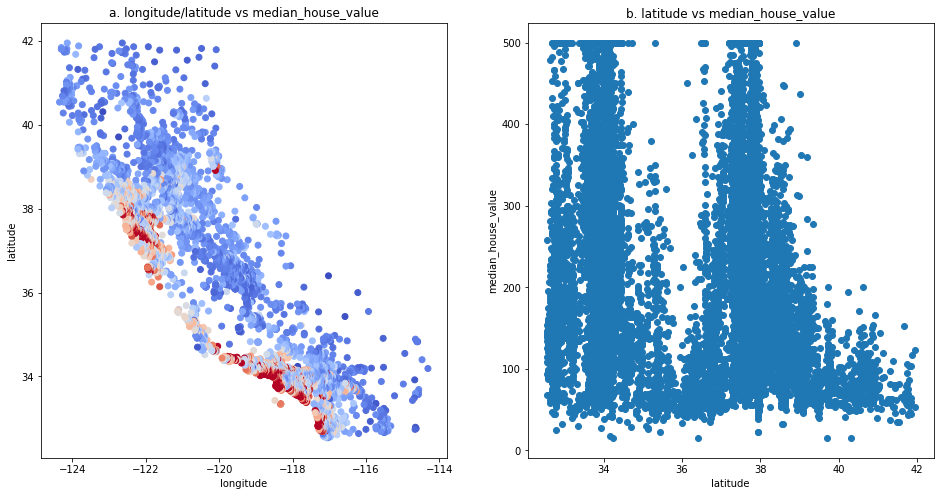

In [12]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("a. longitude/latitude vs median_house_value")
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.scatter(california_housing_dataframe["longitude"],
            california_housing_dataframe["latitude"],
            cmap="coolwarm",
            c=california_housing_dataframe["median_house_value"] / california_housing_dataframe["median_house_value"].max())

plt.subplot(1, 2, 2)
plt.title("b. latitude vs median_house_value")
plt.xlabel('latitude')
plt.ylabel('median_house_value')
plt.scatter(california_housing_dataframe["latitude"], california_housing_dataframe["median_house_value"])
_ = plt.plot()

The plots above give us some insight to the correlation of location to median_house values. Plot a makes a nice visual map of california with the red zones having the highest prices. The red zones overlay the citiies of Los Angeles to the south and San Fransisco to the north. This easily explains the relative higher values of houses in those zones. 

Plot b delves into an explanation of the non correlation between location and prices. There is hardly any linear correlation between the total datapoints in latitude and the median house values. if we considered only the peaks of the scatter plot, we can infer a linear relationship. This peaks also indicate the red zones in the scatter plot a. To use these relationship in our model, we can separate the latitude into bins where the bins containing the peaks would infer a higher price in the model.

This is a typical example of how having domain understanding of the data being analyzed makes a significant difference in the quality of the machine learning model.


### Putting it all together

So far, we've studied the dataset and made insights on the quality of the data. We've also looked into techniques to improve the quality of the data on machine learning. There's more that could have been done to improve the quality of the dataset but focus was placed on the mentioned techniques because they were the most relevant to this dataset. Simply put, excellent data engineering results in excellent ML models whereas bad data engineering.... well, its self explanatory.

To start to build a Linear regression model, we first want to randomize the dataset so as to eliminate any bias in the training, validation, and test data sets. We also need to split the data set into 60% for training, 20% for validation and the rest for testing. The idea behind splitting data is to avoid overfitting. we want the model to be able to predict from the test dataor any other external data for the first time without cheating.

To randomize the data, we call

In [13]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

We then separate the important columns "latitude", "median_income" into features and "median_house_value" labels and also divide  into training, validation and testing sets.

In [14]:
#returns a dataframe with the preprocessed input features  
def pre_features(california_housing_dataframe):
    #create another dataframe from the features to exclude median_house_value
    input_features = california_housing_dataframe[["latitude", "median_income"]]  
    return input_features

#returns a dataframe with the preprocessed input labels 
def pre_labels(california_housing_dataframe):
    input_labels = california_housing_dataframe[["median_house_value"]]
    return input_labels

preprocessed_features = pre_features(california_housing_dataframe)
preprocessed_labels = pre_labels(california_housing_dataframe)


# split the first 10000 (out of 17000) examples for training.
training_features = preprocessed_features.head(10000)
training_targets = preprocessed_labels.head(10000)

# split the next 3500 (out of 17000) examples for validation.
validation_features = preprocessed_features.iloc[10000:13500]
validation_targets = preprocessed_labels.iloc[10000:13500]

# split the last 3500 (out of 17000) examples for validation.
testing_features = preprocessed_features.tail(3500)
testing_targets = preprocessed_labels.tail(3500)

The function below creates 11 equal buckets from the latitude column based on an increment of 1 latitude. This allows us to isolate the highly priced areas around 32-35 and 37-39 and allow them influence the model separately. Finer bucketing separation schemes exist but this simplistic equal distribution of ones works fine for this dataset. 

Bucketing creates an eleven element vector of the form 

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

This is interpreted as a latitude in the 34-35 region. The model can then learn that prices in that area are relatively higher than those in the 43-44 region. This representation of features in a vector form is also called one hot encoding. it is an essential method to make sense of data to machine learning models.

In [15]:
# Takes a dataframe of features and returns a transfromed set of features with binned latitude values 
def select_and_transform_features(source_features):
    LATITUDE_RANGES = zip(range(32, 44), range(33, 45))
    transformed_features = pd.DataFrame()
    transformed_features["median_income"] = source_features["median_income"]
    for r in LATITUDE_RANGES:
        transformed_features["latitude_%d_to_%d" % r] = source_features["latitude"].apply(
            lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
    return transformed_features

transformed_training_features = select_and_transform_features(training_features)
transformed_validation_features = select_and_transform_features(validation_features)
transformed_testing_features = select_and_transform_features(testing_features)

#Examine what the one hot encoding looks like
transformed_training_features

,median_income,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41,latitude_41_to_42,latitude_42_to_43,latitude_43_to_44
3800,5.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12745,3.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16055,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3098,6.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13946,1.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8989,6.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2447,5.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6538,4.9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16794,3.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Define tensorflow's input function to pair features and labels as tensors

In [32]:
def train_input_fn(features, labels, batch_size = 1, shuffle = True, num_epochs = None):
    
    features = {key : np.array(item) for key, item in dict(features).items()}
    
    #must take in a dict of names and arrays and a 1d array
    ds = Dataset.from_tensor_slices((features, labels))
    
    #batch and repeat for training.
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    #Shuffle, if applicable
    if shuffle:
        ds.shuffle(buffer_size = 10000)
    my_features, labels = ds.make_one_shot_iterator().get_next()
    
    return my_features, labels

def predict_input_fn(features, labels = None, batch_size = 1):
    """An input function for evaluation or prediction"""
    features = {key : np.array(item) for key, item in dict(features).items()}
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    ds = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    ds = ds.batch(batch_size)

    # Return the dataset.
    return ds


Finally train the model. As the aim of this notebook is not necessarily to explain the dynamics of linear regression and gradient descent, but to analyse the methods above that make the most of the dataset and regression, we will refrain from getting into the nitty gritty of linear regression and gradient descent. We will only skim through a logical workflow of how  linear regression and gradient descent works with training and validation. 

The logic behind model training and validation is as follows

* Continuously pass a shuffled batch of the features, label pair into the model
* After each period, calculate the mean squared error of a random feature, label pair from the training set and store it
* Also validate the model with a random feature, label pair from the validation set
* Keep looping through the number of periods till the prediction from the training set converges

Note that only data from the training set is passed to the model in batches, the validation set is passed as singles only to validate after every period of training. We can therefore be confident that we have not overfit the model to the validation set.

The idea is that eventually, we would have covered enough datapoints from the training set such that the gradient descent would have converged at the local minima and loss can no longer be reduced.

We can then throw in a random test data and measure how well the model works

training RMSE for period 0 is 205.80813382519972
validation RMSE for period 0 is 207.30040393000485
training RMSE for period 1 is 176.11972840920882
validation RMSE for period 1 is 177.16758385107119
training RMSE for period 2 is 147.89055861141532
validation RMSE for period 2 is 148.50521527022457
training RMSE for period 3 is 122.13506632643484
validation RMSE for period 3 is 122.34949626424591
training RMSE for period 4 is 100.76623903886411
validation RMSE for period 4 is 100.67157651489511
training RMSE for period 5 is 87.44080380755142
validation RMSE for period 5 is 87.25294310164865
training RMSE for period 6 is 83.91232609203288
validation RMSE for period 6 is 83.8403516575963
training RMSE for period 7 is 83.5463362983002
validation RMSE for period 7 is 83.53359745117157
training RMSE for period 8 is 83.27908682249662
validation RMSE for period 8 is 83.29372937630055
training RMSE for period 9 is 83.02109455019199
validation RMSE for period 9 is 83.0571218695752
Training fini

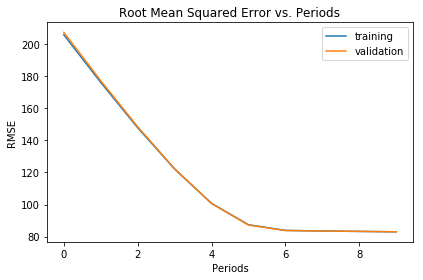

In [23]:
def train_fn(steps, learning_rate, batch_size):
    
    periods = 10
    steps_per_period = steps/periods
    
    training_input_fn = lambda : train_input_fn(transformed_training_features,
                                          training_targets,
                                          batch_size= batch_size)
    
    training_predict_input_fn = lambda : predict_input_fn(transformed_training_features, training_targets) #predict is used to calculate the mean squared loss
    
    validate_predict_input_fn = lambda : predict_input_fn(transformed_validation_features, validation_targets)
    
    #define multiple feature columns
    feature_columns = set([tf.feature_column.numeric_column(i) for i in 
         transformed_training_features])
        
    #configure the linear regressor
    #first configure the optimizer as gradient descent
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    #also clip the gradients so they dont get too large
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    
    linear_regressor = tf.estimator.LinearRegressor(feature_columns = feature_columns,
                                                    optimizer = my_optimizer)
    #lists to store the root mean square errors
    training_rmse = []
    validation_rmse = []
    
    #now train but do so in a loop so we can track loss
    for i in range(periods):
        linear_regressor.train(input_fn = training_input_fn, steps = steps_per_period)
        
        predictions_training = linear_regressor.predict(input_fn = training_predict_input_fn)
        #convert predictions to numpy array
        predictions_training = np.array([x['predictions'][0] for x in predictions_training])
        
        #calculate mean squared loss
        MSE = metrics.mean_squared_error(predictions_training, training_targets)
        RMSE = math.sqrt(MSE)
        print("training RMSE for period {i} is {RMSE}".format(**locals()))
        
        #for validation, we only predict with the model
        predictions_validation = linear_regressor.predict(input_fn = validate_predict_input_fn)
        predictions_validation = np.array([x['predictions'][0] for x in predictions_validation])
    
        MSE = metrics.mean_squared_error(predictions_validation, validation_targets)
        RMSE2 = math.sqrt(MSE)
        print("validation RMSE for period {i} is {RMSE2}".format(**locals()))
        
        # store the root mean square errors
        training_rmse.append(RMSE)
        validation_rmse.append(RMSE2)
        
    print("Training finished")
    
    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    
    return linear_regressor

#call train function
trained_regressor = train_fn(1500, 0.01,50)



The root mean square error is a measure of how far the weights of the linear regression line are from the actually known labels. The lower the RMSE, the better the prediction.

The important thing to note about the plot above is how quickly the RMSE converged to a local minima. This is a function of tuning the learning rate, batch size, and total steps. Another thing most ML engineers spend quite some time on. Passing in more data or increasing training time will not do much by way of improving the model. Instead, smarter feature engineering will always save time and compute costs. 

There is a lot of literature on the california housing dataset and some have reduced the RMSE to as low as 60 using some other feaature engineering techniques.

To use the testing set we can call

In [72]:
testing_predict = trained_regressor.predict(lambda : predict_input_fn(transformed_testing_features))
testing_predict = np.array([x['predictions'][0] for x in testing_predict])
tested_vs_original = pd.DataFrame()
tested_vs_original["training_predict"] = testing_predict
tested_vs_original["original"] = testing_targets
tested_vs_original.dropna().tail(10)


,training_predict,original
3447,235.3,193.8
3454,78.7,159.0
3456,203.7,197.8
3462,160.6,181.3
3463,214.0,260.3
3469,118.4,350.0
3480,91.6,166.0
3495,167.6,247.4
3496,139.2,267.6
3498,218.4,226.6


In [73]:
MSE = metrics.mean_squared_error(testing_predict, testing_targets)
print(math.sqrt(MSE))

84.9261011163121


Note that a lot we scaled down from a thousand so the model is on average + or - 84,000 correct. Of course this is not acceptable as a decison index but the aim of this notebook wasnt to neccesarily build the best ML model for the california housing dataset but rather to have some practice with the tools of feature engineering and a general ML workflow.

### olaoluadesanya@yahoo.com
### https://www.linkedin.com/in/oadesanya/
### https://github.com/olaoluadesanya